In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 10.1 MB/s eta 0:00:00


In [ ]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import xgboost
from balance_dataset import balance_dataset
import pandas as pd

In [3]:
# Load dataset

dataset = pd.read_csv("Data/handcraft_data.csv")
dataset = dataset[dataset["patient"] < 24]

tabular_data = pd.read_csv("Data/scores_for classification_2.csv")

age = []
gender = []
target = []
inpatient = []
for i in range(0, len(dataset)):
    real_patient = dataset.loc[i]["patient"]
    age.append(tabular_data.iloc[int(real_patient)-1]["age"])
    gender.append(tabular_data.iloc[int(real_patient) - 1]["gender"])
    t = tabular_data.iloc[int(real_patient)-1]["afftype"]
    if int(t) == 1 or int(t) == 3:
        target.append(0)
    else:
        target.append(1)
    inpatient.append(tabular_data.iloc[int(real_patient)-1]["inpatient"])

dataset["age"] = age
dataset["gender"] = gender
dataset["target"] = target
dataset["inpatient"] = inpatient


dataset = balance_dataset(dataset)


X = dataset.loc[:, ~dataset.columns.isin(['patient', 'target'])]
Y = dataset['target']

In [4]:
# train XGBoost model
model = xgboost.XGBClassifier(learning_rate=0.05, n_estimators=600, objective='binary:logistic',
                              nthread=1, max_depth=2, min_child_weight=2, gamma=0.3, colsample_bytree=1.0,
                              subsample=1.0, random_state=2023)

In [5]:
seed = 2023
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

model.fit(X_train,y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.71%


In [6]:
def f(x):
    return shap.links.identity(model.predict_proba(x, validate_features=False)[:,1])

# explain the model's predictions using SHAP values
masker = shap.maskers.Independent(data = X_train)
explainer = shap.Explainer(f, masker = masker)
shap_values = explainer(X_train)

Exact explainer: 169it [00:14,  9.74it/s]                         


In [8]:
Y[0]

0

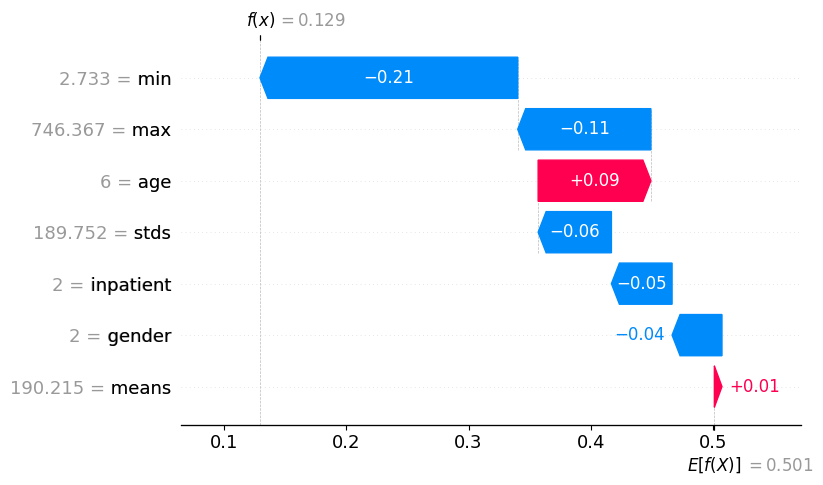

In [7]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

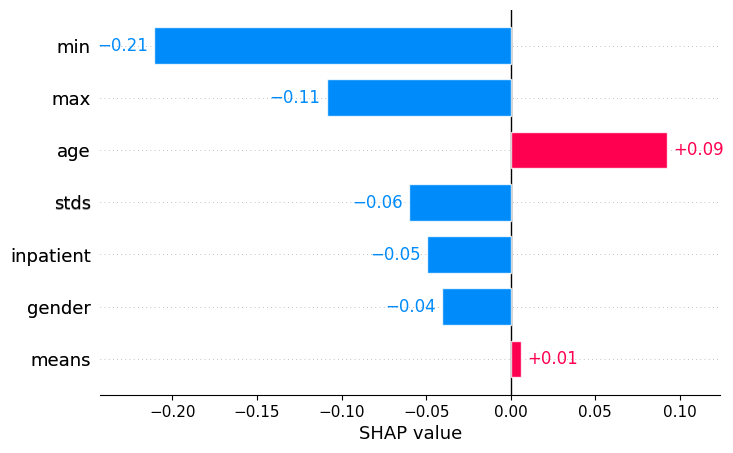

In [9]:
# plot the global importance of each feature
shap.plots.bar(shap_values[0])

In [10]:
shap.plots.initjs()

# visualize the first prediction's explanation
shap.plots.force(shap_values[0])

In [11]:
shap.plots.initjs()

# visualize the first prediction's explanation
shap.plots.force(shap_values)

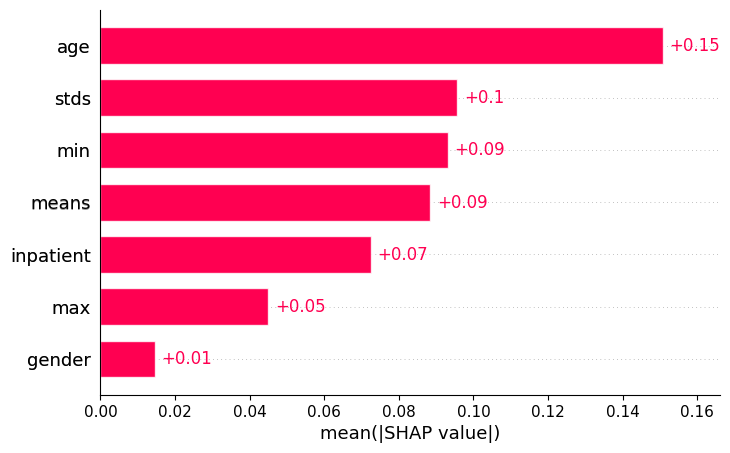

In [12]:
# plot the global importance of each feature
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


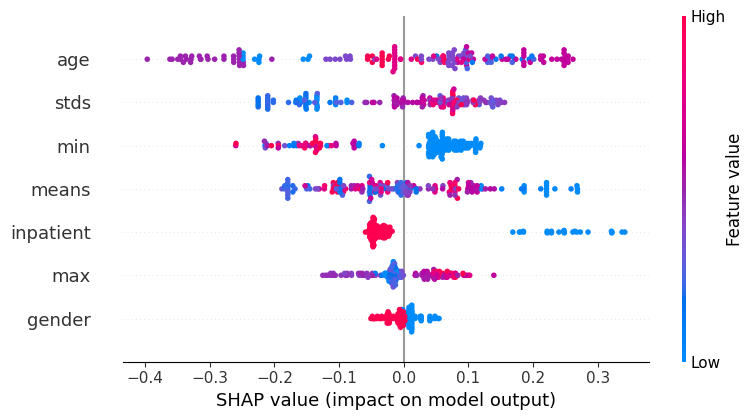

In [13]:
# plot the distribution of importances for each feature over all samples
shap.summary_plot(shap_values, X_train)